<a href="https://colab.research.google.com/github/samuel0922/my_ex/blob/main/%5BEX_16%5DSEGMENTATION_MAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [EX_16]SEGMENTATION_MAP
### * 프로젝트 개요 
도로의 레이블 정보를 활용해 이미지를 생성해낸 결과인 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것.

### * 목차
* STEP 0. 환경 설정
* STEP 1. 데이터 준비
* STEP 2. 데이터 분석 및 전처리
* STEP 3. 모델 준비
* STEP 4. 학습 및 테스트
* STEP 5. 시각화

* 루브릭 및 회고

# STEP 0. 환경 설정


In [33]:
# 필요한 라이브러리 임포트

import os

import cv2
import imageio  
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import data  
from tensorflow import image  

import tensorflow_datasets as tfds 
from tensorflow.keras import losses  
from tensorflow.keras import optimizers  
from tensorflow.keras import layers, Input, Model   
from tensorflow.keras.preprocessing.image import random_rotation  

## STEP 1. 데이터 준비

In [2]:
# 데이터 경로 설정

train_data_path = '/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/train/'
val_data_path = '/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/val/'
print(val_data_path)
print("number of train examples :", len(os.listdir(train_data_path)))
print("number of train examples :", len(os.listdir(val_data_path)))

/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/val/
number of train examples : 1002
number of train examples : 5


## STEP 2. 데이터 분석 및 전처리

/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/train/916.jpg
/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/train/476.jpg
/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/train/540.jpg
/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/train/567.jpg
/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/train/355.jpg
/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/train/453.jpg


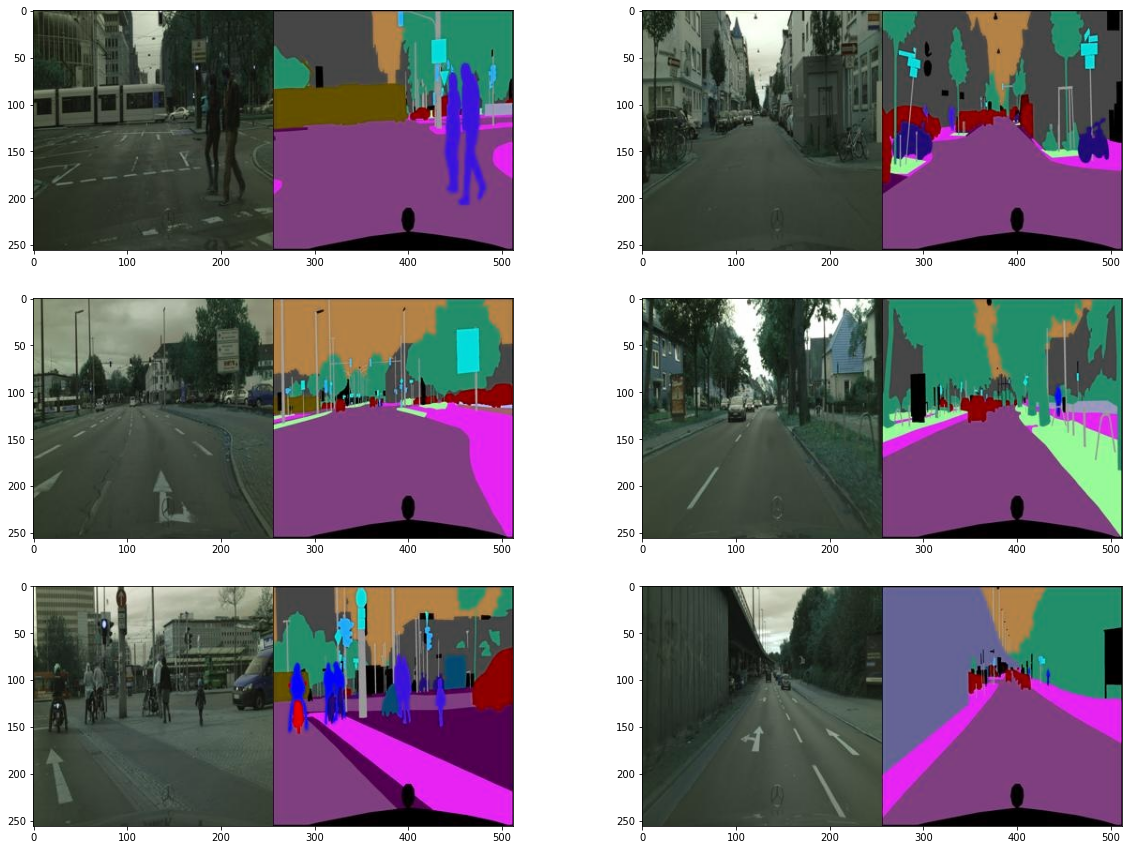

In [3]:
# 이미지 확인

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    print(f)
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# 이미지 하나 열어 크기 확인

f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


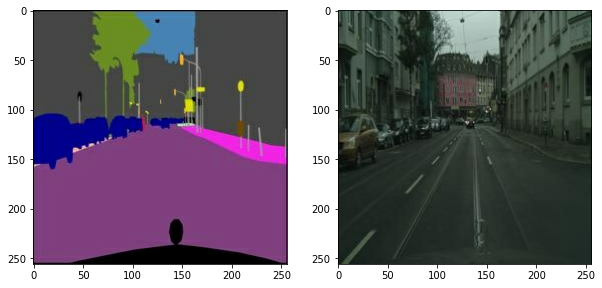

In [5]:
# 모델 학습에 사용할 이미지 분할

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(colored), normalize(sketch)

f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [6]:
# 데이터 argumentation 해 주는 함수 
# 데이터 argumentation에 다른 어떤 다양한 방법들이 사용될까?

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


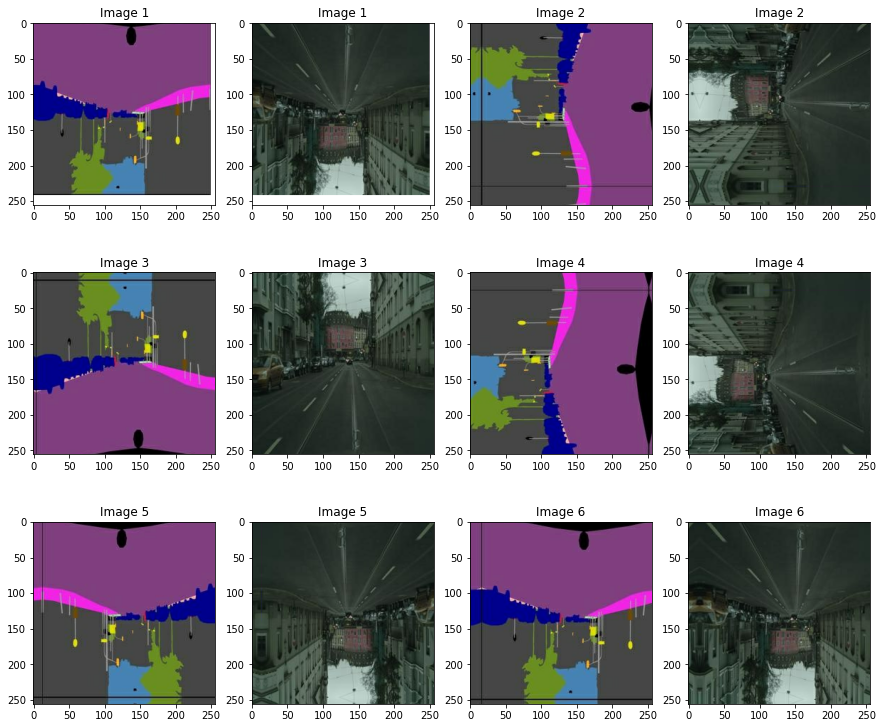

In [7]:
# 구성한 함수를 데이터에 적용해 봄

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

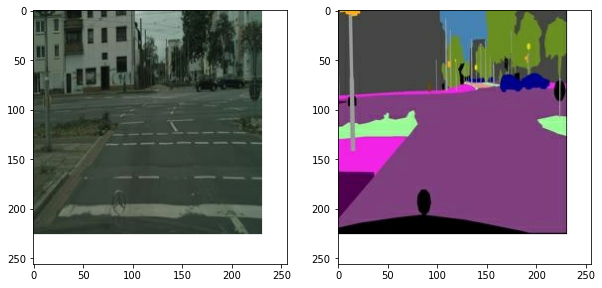

In [8]:
# 과정들을 학습 데이터에 적용해 결과 확인해 봄

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## STEP 3. 모델 구성

### S3-1. GENERATOR 구성하기

In [9]:
# Generator 구현하기

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [10]:
# Encoder 구성

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [11]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

### S3-2. DISCRIMINATOR 구성하기

In [12]:
# Decoder 

class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [13]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

### S3-3. EncoderDecorderGenerator 구성

In [14]:
# EncoderDecoderGenerator

class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [15]:
# 기본 블록 정의

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


### S3-4. U-NET Generator 정의

In [16]:
# U-Net Generator 정의

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [17]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

In [18]:
# Discriminator에 필요한 기본블록 만들기

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [19]:
# 출력 크기 확인

inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_45 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

### S3-4. DISCRIMINATOR 만들기

In [20]:
# Discriminator 만들기

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [21]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

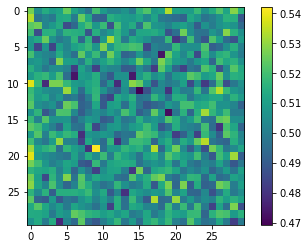

In [22]:
# 시험 삼아 출력 확인

x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## STEP 4. 학습

In [23]:
# 손실 함수 정의

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)



In [24]:

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)



In [25]:
# 가중치 업데이트하는 함수 

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss



In [26]:
val_path = [val_data_path + path for path in os.listdir(val_data_path)]
print(val_data_path)
save_images = []
for path in val_path:
    img, _ = load_img(path)
    save_images.append(img)

save_images = np.array(save_images)

def save_val_img(path):
    predict = generator(save_images)
    predict = denormalize(predict)

    plt.figure(figsize=(4, 4))
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    for i in range(4):
        plt.subplot(2, 2, 1+i)
        plt.imshow(predict[i])
        plt.axis("off")
    plt.savefig(path)
    plt.clf()

/content/drive/MyDrive/aiffel/conditional_generation/dataset/cityscapes/val/


In [35]:
# 학습 진행

EPOCHS =500
gen_loss_list, dis_loss_list, L1_loss_list = [], [], []

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    if (epoch + 1) % 10 == 0:
      save_val_img(f"/content/drive/MyDrive/aiffel/conditional_generation/dataset/frame/{epoch}.png")
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)

        gen_loss_list.append(g_loss)
        dis_loss_list.append(d_loss)
        L1_loss_list.append(l1_loss)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
EPOCH[169] - STEP[10]                     
Generator_loss:5.2241                     
L1_loss:0.1725                     
Discriminator_loss:0.0184

EPOCH[169] - STEP[20]                     
Generator_loss:7.3454                     
L1_loss:0.1127                     
Discriminator_loss:3.1264

EPOCH[169] - STEP[30]                     
Generator_loss:7.4339                     
L1_loss:0.1387                     
Discriminator_loss:0.0070

EPOCH[169] - STEP[40]                     
Generator_loss:4.9445                     
L1_loss:0.1192                     
Discriminator_loss:0.0401

EPOCH[169] - STEP[50]                     
Generator_loss:8.3335                     
L1_loss:0.1057                     
Discriminator_loss:0.2365

EPOCH[169] - STEP[60]                     
Generator_loss:5.0879                     
L1_loss:0.1206                     
Discriminator_loss:0.1096

EPOCH[169] - STEP[70]                     
Generator_loss:3.8317      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
EPOCH[461] - STEP[10]                     
Generator_loss:10.6133                     
L1_loss:0.1393                     
Discriminator_loss:0.0631

EPOCH[461] - STEP[20]                     
Generator_loss:7.8263                     
L1_loss:0.1015                     
Discriminator_loss:0.0936

EPOCH[461] - STEP[30]                     
Generator_loss:3.4001                     
L1_loss:0.0830                     
Discriminator_loss:0.1134

EPOCH[461] - STEP[40]                     
Generator_loss:3.2674                     
L1_loss:0.1003                     
Discriminator_loss:0.2328

EPOCH[461] - STEP[50]                     
Generator_loss:4.3440                     
L1_loss:0.1056                     
Discriminator_loss:0.3285

EPOCH[461] - STEP[60]                     
Generator_loss:3.6595                     
L1_loss:0.0785                     
Discriminator_loss:0.1158

EPOCH[461] - STEP[70]                     
Generator_loss:3.8037     

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

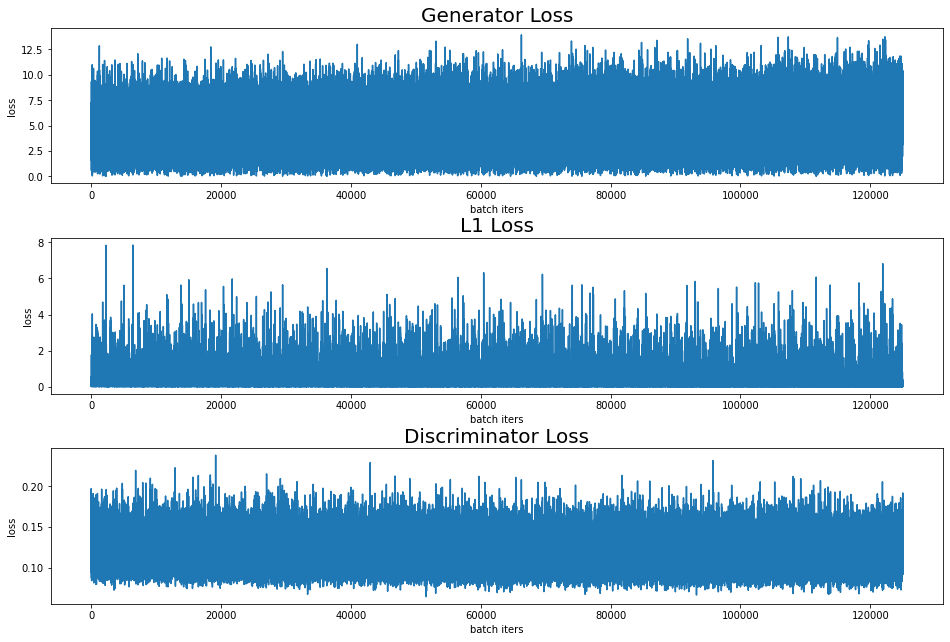

In [36]:
# 학습 과정 시각화 (1) : 손실함수 

plt.figure(figsize=(16,10))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(3, 1, 1)
plt.plot(gen_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Generator Loss', fontsize=20)

plt.subplot(3, 1, 2) 
plt.plot(dis_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('L1 Loss', fontsize=20)

plt.subplot(3, 1, 3)
plt.plot(L1_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Discriminator Loss', fontsize=20)

plt.show()

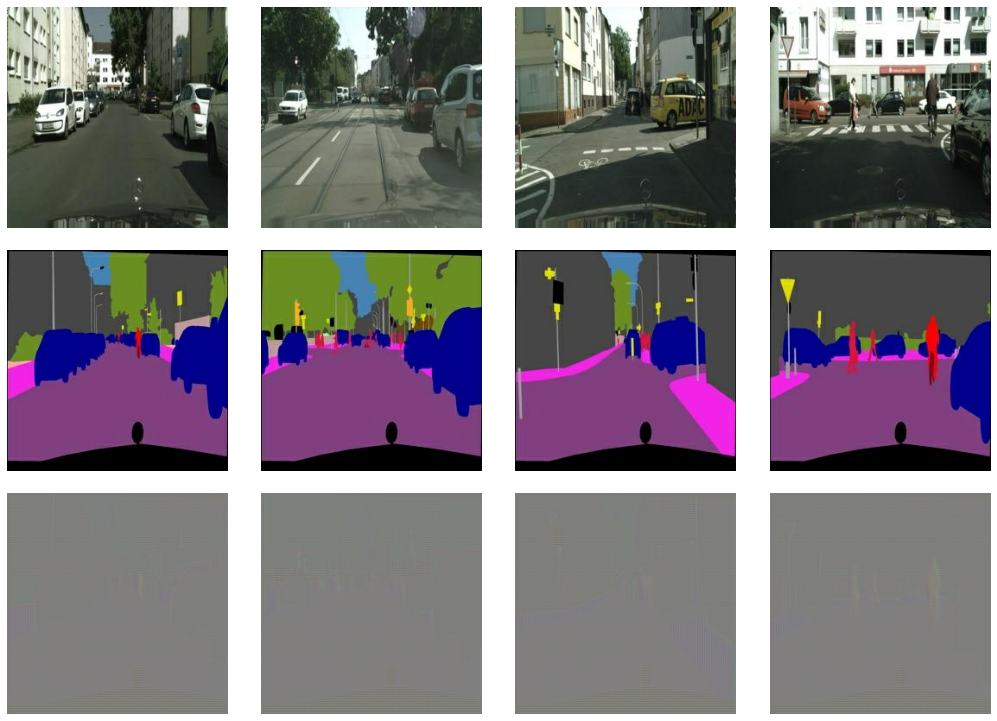

In [37]:
# 학습 과정 시각화 (2) : 학습 중 이미지 변화
val_path = [val_data_path + path for path in os.listdir(val_data_path)]

seg_images, real_images = [], []
for path in val_path:
    seg_img, real_img = load_img(path)
    seg_images.append(seg_img)
    real_images.append(real_img)

seg_images = np.array(seg_images)

real_images = np.array(real_images)
real_images = (real_images + 1) * 127.5
real_images = real_images.astype(np.uint8)

predict = generator(seg_images)
predict = denormalize(predict)

seg_images = (seg_images + 1) * 127.5
seg_images = seg_images.astype(np.uint8)

plt.figure(figsize=(18, 13))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(real_images[i])
    plt.axis("off")
    
    plt.subplot(3, 4, i + 5)
    plt.imshow(seg_images[i])
    plt.axis("off")
    
    plt.subplot(3, 4, i + 9)
    plt.imshow(predict[i])
    plt.axis("off")

In [38]:
epoch_nums = [int(path.replace(".png", "")) for path in os.listdir("/content/drive/MyDrive/aiffel/conditional_generation/dataset/frame")]
epoch_nums.sort()

img_path_list = [f"/content/drive/MyDrive/aiffel/conditional_generation/dataset/frame/{epoch}.png" for epoch in epoch_nums]
img_list = [cv2.imread(img_path) for img_path in img_path_list]

imageio.mimsave("/content/drive/MyDrive/aiffel/conditional_generation/dataset/frame.gif", img_list)


## [ 루브릭 ]
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.<br>
* 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시함.<br>
2.  pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행함.<br>
* U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인함.<br>
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.<br>
* 각각 10, 50, 300, 500 epoch 씩의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인, 비교해 보았음.<br><br>
=> EPOCH에 따른 결과 비교 ---------------------------------
  > * EPOCH = 10
  > EPOCH[10] - STEP[250]                     
    Generator_loss:1.7985   
    L1_loss:0.1772   
    Discriminator_loss:0.6407

  > * EPOCH = 50
  > EPOCH[50] - STEP[250]                     
    Generator_loss:1.2346                     
    L1_loss:0.1700                     
    Discriminator_loss:0.9985

  > * EPOCH = 300
    EPOCH[300] - STEP[250]                     
    Generator_loss:4.6072                     
    L1_loss:0.0969                     
    Discriminator_loss:0.0678

  > * EPOCH = 500
  EPOCH[500] - STEP[250]                     
  Generator_loss:4.6969                     
  L1_loss:0.1131                     
  Discriminator_loss:0.0603

###-----------------------------------------------

## [ 회고 ]
* GAN모델에 대해 기본적인 개념을 이해하였고, 이번 익스의 경우엔 노드의 내용에서 <br>
크게 벗어나지 않았지만 생성자나 평가자의 구현 내용에 대한 설명이 이해하기에 쉽지는 않았음<br>
* 시간이 촉박할 듯 해 학습을 EPOCH 300정도로만 시켜봤는데 생성된 이미지가 조금씩 개선되는 것은<br>
알 수 있었지만 충분한 품질로 만들어지지 않았음. EPOCH 500으로 훈련시켜 본 결과를 반영하려고 함.
* EPOCH 500이후에도 생성된 이미지의 품질은 매우 낮음.. 문제가 뭔지 살펴 봐야할 듯...<br>  
* GAN은 매우 흥미로운 모델로 다양한 활용분야가 있을 것 같은데 시간에 쫓겨 심도있게 내용을<br>
살펴보지 못하였기에 고잉디퍼 기간동안 좀 더 공부해야 할 것으로 생각됨.<br>







